# Notebook

A Jupyter notebook to preprocess datasets for sentiment analysis and churn prediction.

## 1. Import Required Libraries

Import necessary libraries and download NLTK resources.

In [ ]:
import pandas as pd
import numpy as np
import re
import string
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
import shap
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Download NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shahriarpshuvo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/shahriarpshuvo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/shahriarpshuvo/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## 2. Define Utility Functions

Define text cleaning and lemmatization functions.

In [ ]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def lemmatize_text(text, lemmatizer, stop_words):
    words = text.split()
    lemmatized = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return ' '.join(lemmatized)

## 3. Preprocess Amazon Fine Food Reviews

Clean, label, and split the Amazon reviews dataset.

In [ ]:
def preprocess_amazon_reviews(input_path, output_dir):
    df = pd.read_csv(input_path)
    df = df[['Text','Score']].dropna()
    df = df[df.Score.isin([1,2,3,4,5])]
    df['label'] = df.Score.apply(lambda x: 'negative' if x<=2 else 'neutral' if x==3 else 'positive')

    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    df['clean_text'] = df.Text.apply(clean_text)
    df['clean_text'] = df.clean_text.apply(lambda x: lemmatize_text(x, lemmatizer, stop_words))

    df_final = df[['clean_text','label']]

    train, vt = train_test_split(df_final, test_size=0.3, stratify=df_final.label, random_state=42)
    val, test = train_test_split(vt, test_size=0.5, stratify=vt.label, random_state=42)

    train.to_csv(os.path.join(output_dir,'sentiment_train.csv'), index=False)
    val.to_csv(os.path.join(output_dir,'sentiment_val.csv'), index=False)
    test.to_csv(os.path.join(output_dir,'sentiment_test.csv'), index=False)

    return train, val, test

## 4. Preprocess Telco Customer Churn

Clean, encode, and split the Telco churn dataset.

In [ ]:
def preprocess_telco_churn(input_path, output_dir):
    df = pd.read_csv(input_path)
    df.dropna(inplace=True)
    df['Churn'] = df.Churn.map({'Yes':1,'No':0})

    df = df.drop(columns=['customerID'])
    cat_cols = df.select_dtypes(include=['object']).columns.tolist()
    df = pd.get_dummies(df, columns=cat_cols)

    train, vt = train_test_split(df, test_size=0.3, stratify=df.Churn, random_state=42)
    val, test = train_test_split(vt, test_size=0.5, stratify=vt.Churn, random_state=42)

    train.to_csv(os.path.join(output_dir,'churn_train.csv'), index=False)
    val.to_csv(os.path.join(output_dir,'churn_val.csv'), index=False)
    test.to_csv(os.path.join(output_dir,'churn_test.csv'), index=False)

    return train, val, test

## 5. Run Preprocessing Scripts

Execute preprocessing for both datasets and save outputs.

In [ ]:
data_dir = '../data'
train_s, val_s, test_s = preprocess_amazon_reviews(f"{data_dir}/amazon_reviews.csv", data_dir)
train_c, val_c, test_c = preprocess_telco_churn(f"{data_dir}/telco_churn.csv", data_dir)
print('✅ Preprocessing complete')

## 6. Train Churn Prediction Models

Train Random Forest and Logistic Regression on the churn dataset.

In [ ]:
# Prepare features and labels
Xc_train = train_c.drop(columns=['Churn'])
yc_train = train_c['Churn']
Xc_val   = val_c.drop(columns=['Churn'])
yc_val   = val_c['Churn']
Xc_test  = test_c.drop(columns=['Churn'])
yc_test  = test_c['Churn']

# Scale features
scaler = StandardScaler().fit(Xc_train)
Xc_train_s = scaler.transform(Xc_train)
Xc_val_s   = scaler.transform(Xc_val)
Xc_test_s  = scaler.transform(Xc_test)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(Xc_train_s, yc_train)
pred_rf = rf.predict(Xc_test_s)
prob_rf = rf.predict_proba(Xc_test_s)[:,1]
print('Random Forest Classification Report:')
print(classification_report(yc_test, pred_rf))
print(f'RF AUC-ROC: {roc_auc_score(yc_test, prob_rf):.4f}')
joblib.dump(rf, '../models/saved_churn_rf.pkl')
joblib.dump(scaler, '../models/saved_scaler.pkl')

# Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(Xc_train_s, yc_train)
pred_lr = lr.predict(Xc_test_s)
prob_lr = lr.predict_proba(Xc_test_s)[:,1]
print('Logistic Regression Classification Report:')
print(classification_report(yc_test, pred_lr))
print(f'LR AUC-ROC: {roc_auc_score(yc_test, prob_lr):.4f}')
joblib.dump(lr, '../models/saved_churn_lr.pkl')

## 7. Train Sentiment Classification Models

Train SVM and LSTM models on the preprocessed sentiment data.

### 7.1 SVM Classifier

In [ ]:
tfidf = TfidfVectorizer(max_features=5000)
X_train_s = tfidf.fit_transform(train_s['clean_text'])
X_test_s  = tfidf.transform(test_s['clean_text'])

le_s = LabelEncoder()
y_train_s = le_s.fit_transform(train_s['label'])
y_test_s  = le_s.transform(test_s['label'])

svm = LinearSVC()
svm.fit(X_train_s, y_train_s)

y_pred_s = svm.predict(X_test_s)
print("SVM Classification Report:")
print(classification_report(y_test_s, y_pred_s, target_names=le_s.classes_))

joblib.dump(svm, '../models/saved_svm.pkl')
joblib.dump(tfidf, '../models/saved_tfidf.pkl')

SVM Classification Report:
              precision    recall  f1-score   support

    negative       0.72      0.67      0.70     12306
     neutral       0.59      0.11      0.19      6396
    positive       0.89      0.97      0.93     66567

    accuracy                           0.86     85269
   macro avg       0.73      0.58      0.60     85269
weighted avg       0.84      0.86      0.84     85269



['../models/saved_tfidf.pkl']

### 7.2 LSTM Classifier

In [ ]:
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_s['clean_text'])

def to_padded_seqs(df):
    seqs = tokenizer.texts_to_sequences(df['clean_text'])
    return pad_sequences(seqs, maxlen=100, padding='post')

X_tr = to_padded_seqs(train_s)
X_val = to_padded_seqs(val_s)
X_te = to_padded_seqs(test_s)

le_l = LabelEncoder()
y_tr = to_categorical(le_l.fit_transform(train_s['label']))
y_val = to_categorical(le_l.transform(val_s['label']))
y_te = to_categorical(le_l.transform(test_s['label']))

model = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=100),
    LSTM(64, return_sequences=True),
    Dropout(0.5),
    LSTM(32),
    Dense(3, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_tr, y_tr, validation_data=(X_val, y_val), epochs=5, batch_size=32)

loss, acc = model.evaluate(X_te, y_te, verbose=0)
print(f"LSTM Test Accuracy: {acc:.4f}")

model.save('../models/saved_lstm.h5')
joblib.dump(tokenizer, '../models/saved_tokenizer.pkl')

Epoch 1/5


/Users/shahriarpshuvo/Academic/research-methodology-code/.venv/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


12435/12435 ━━━━━━━━━━━━━━━━━━━━ 351s 28ms/step - accuracy: 0.7835 - loss: 0.6488 - val_accuracy: 0.8514 - val_loss: 0.4070
Epoch 2/5
12435/12435 ━━━━━━━━━━━━━━━━━━━━ 351s 28ms/step - accuracy: 0.7835 - loss: 0.6488 - val_accuracy: 0.8514 - val_loss: 0.4070
Epoch 2/5
12435/12435 ━━━━━━━━━━━━━━━━━━━━ 392s 32ms/step - accuracy: 0.8603 - loss: 0.3845 - val_accuracy: 0.8664 - val_loss: 0.3678
Epoch 3/5
12435/12435 ━━━━━━━━━━━━━━━━━━━━ 392s 32ms/step - accuracy: 0.8603 - loss: 0.3845 - val_accuracy: 0.8664 - val_loss: 0.3678
Epoch 3/5
12435/12435 ━━━━━━━━━━━━━━━━━━━━ 750s 60ms/step - accuracy: 0.8743 - loss: 0.3412 - val_accuracy: 0.8773 - val_loss: 0.3390
Epoch 4/5
12435/12435 ━━━━━━━━━━━━━━━━━━━━ 750s 60ms/step - accuracy: 0.8743 - loss: 0.3412 - val_accuracy: 0.8773 - val_loss: 0.3390
Epoch 4/5
12435/12435 ━━━━━━━━━━━━━━━━━━━━ 364s 29ms/step - accuracy: 0.8930 - loss: 0.2952 - val_accuracy: 0.8851 - val_loss: 0.3255
Epoch 5/5
12435/12435 ━━━━━━━━━━━━━━━━━━━━ 364s 29ms/step - accuracy: 0.

LSTM Test Accuracy: 0.8909


['../models/saved_tokenizer.pkl']

## 8. Evaluate Models

Evaluate trained models on held‑out test sets.

In [ ]:
# Sentiment Model Evaluation
print("### SVM Evaluation")
print(classification_report(y_test_s, svm.predict(X_test_s), target_names=le_s.classes_))

print("\n### LSTM Evaluation")
loss, acc = model.evaluate(X_te, y_te, verbose=0)
print(f"LSTM Test Accuracy: {acc:.4f}")

# Churn Model Evaluation
print("\n### Logistic Regression Evaluation")
print(classification_report(yc_test, lr.predict(Xc_test_s)))
print(f"LR AUC-ROC: {roc_auc_score(yc_test, prob_lr):.4f}")

print("\n### Random Forest Evaluation")
print(classification_report(yc_test, rf.predict(Xc_test_s)))
print(f"RF AUC-ROC: {roc_auc_score(yc_test, prob_rf):.4f}")

### SVM Evaluation
              precision    recall  f1-score   support

    negative       0.72      0.67      0.70     12306
     neutral       0.59      0.11      0.19      6396
    positive       0.89      0.97      0.93     66567

    accuracy                           0.86     85269
   macro avg       0.73      0.58      0.60     85269
weighted avg       0.84      0.86      0.84     85269


### LSTM Evaluation
LSTM Test Accuracy: 0.8909

### Logistic Regression Evaluation
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       776
           1       0.57      0.51      0.54       281

    accuracy                           0.77      1057
   macro avg       0.70      0.68      0.69      1057
weighted avg       0.76      0.77      0.76      1057

LR AUC-ROC: 0.7889

### Random Forest Evaluation
              precision    recall  f1-score   support

           0       0.82      0.91      0.87       776
           1       0.66      0.

## 9. Explain Churn Predictions

Generate and display a SHAP summary plot for the Random Forest churn model.

100%|===================| 2110/2114 [01:49<00:00]        

<Figure size 640x480 with 0 Axes>

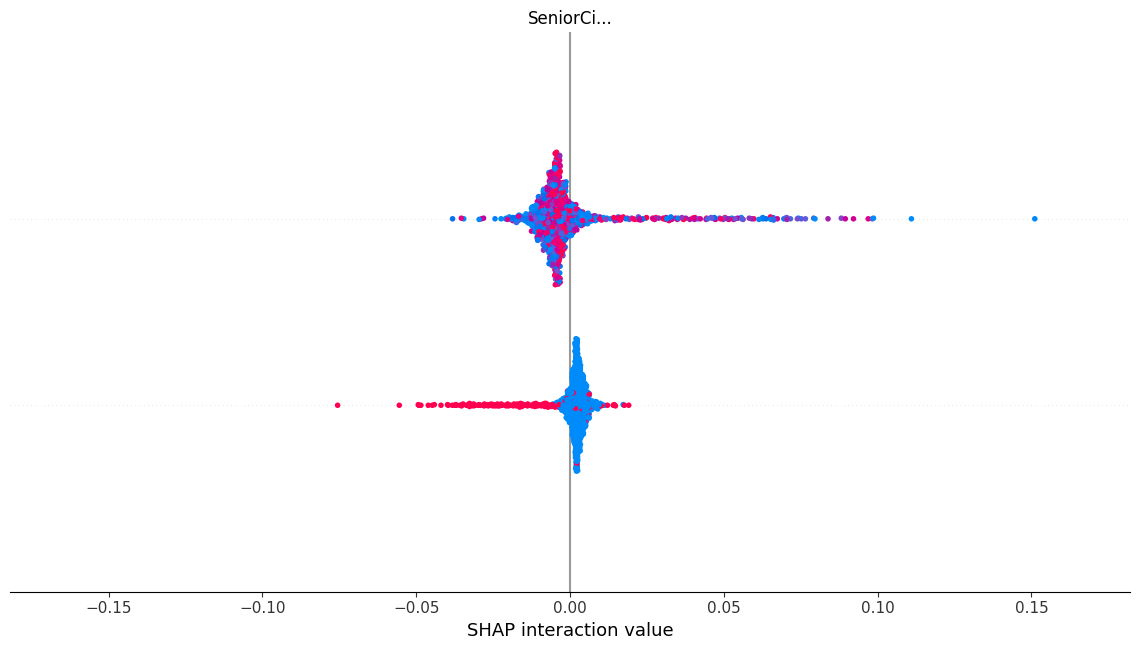

In [9]:
# SHAP explanation - reload model, scaler, and test data
import joblib
import pandas as pd

rf = joblib.load('../models/saved_churn_rf.pkl')
scaler = joblib.load('../models/saved_scaler.pkl')
# Load processed churn test set
churn_test = pd.read_csv('../data/churn_test.csv')
Xc_test = churn_test.drop(columns=['Churn'])
Xc_test_s = scaler.transform(Xc_test)
# Compute SHAP values and plot
explainer = shap.Explainer(rf, Xc_test_s)
sv = explainer(Xc_test_s)
shap.summary_plot(sv, Xc_test, show=False)
plt.tight_layout()
plt.show()